# 【Face Alignment其三】face alignment的逆运算

本文内容为原创，转载需注明出处。

在[《【Face Alignment其二】face alignment的3D投影算法》](https://github.com/konatasick/machine_learning_note/blob/master/face%20alignment2.ipynb)中，
讲解了如何通过3D模型将脸部投影至正面。

本文将继续介绍，如何反向操作，即将原图投影至正面后，再将其投影回原图。更详细地说，就是如何求这个过程的map。

## 3D投影



![a](figure/face_alignment2-1.png)

依然是3D投影的部分，在这里，令(b)中任意一点为$p_i=(x_i,y_i)^T$，其对应的点在(c)中为$p_i^\prime=(x_i^\prime,y_i^\prime)^T$，在3D模型的(d)中为$P_i=(X_i,Y_i,Z_i)^T$。

对于一张输入的图片，将其转化为frontalized face的公式即为：

$$p^\prime\sim C_M C_Q^{-1} p$$

当我们需要求其逆运算时，即为

$$p\sim C_Q C_M^{-1} p^\prime$$

而通过前文可知，我们在求map时实际上用到的是其逆运算，即

$$originmap=C_M C_Q^{-1}*newmap$$

当我们在对图片进行alignment时，我们可以通过 calib.estimate_camera求得$C_Q$，要得到最终结果，我们仍需有$C_M$。

$C_M$也可通过calib.estimate_camera求得，此时函数的输入为3D模型和frontalized facial landmark。


## 计算$C_M$

首先求得正面的facial landmark

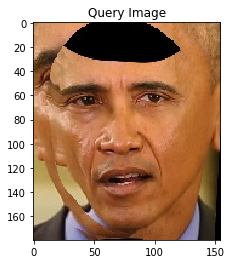

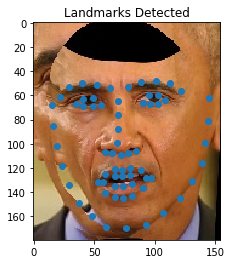

In [1]:
%matplotlib inline
import frontalize
import facial_feature_detector as feature_detection
import camera_calibration as calib
import scipy.io as io
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import imutils


# load query image
frt_img = cv2.imread("frontalized_1.jpg", 1)
org_lmarks = feature_detection.get_landmarks(frt_img)
frt_img=frt_img[int(org_lmarks[0][19,1])-50:int(org_lmarks[0][8,1])+10, int(org_lmarks[0][0,0])-10:int(org_lmarks[0][16,0])+10]
plt.title('Query Image')
plt.imshow(frt_img[:, :, ::-1])

# extract landmarks from the query image
# list containing a 2D array with points (x, y) for each face detected in the query image
lmarks = feature_detection.get_landmarks(frt_img)
plt.figure()
plt.title('Landmarks Detected')
plt.imshow(frt_img[:, :, ::-1])
plt.scatter(lmarks[0][:, 0], lmarks[0][:, 1])

之后载入3D model并计算其投影$C_M$

In [2]:
# load detections performed by dlib library on 3D model and Reference Image
model3D = frontalize.ThreeD_Model("model3Ddlib.mat", 'model_dlib')

# perform camera calibration according to the first face detected
C_M, camera_matrix, rmat, tvec = calib.estimate_camera(model3D, lmarks[0])
print C_M #C_M

[[501.7173 125.2784 -23.4931 52265.5859]
 [4.4926 90.7868 -509.6121 65866.5703]
 [0.0657 0.9883 -0.1373 620.7133]]


## 计算remap

在上一篇我们已经得到$C_Q$和$newmap$

In [3]:
# load query image
img = cv2.imread("1.jpg", 1)
org_lmarks = feature_detection.get_landmarks(img)
img=img[int(org_lmarks[0][19,1])-50:int(org_lmarks[0][8,1])+10, int(org_lmarks[0][0,0])-10:int(org_lmarks[0][16,0])+10]
# extract landmarks from the query image
# list containing a 2D array with points (x, y) for each face detected in the query image
lmarks = feature_detection.get_landmarks(img)
# load detections performed by dlib library on 3D model and Reference Image
model3D = frontalize.ThreeD_Model("model3Ddlib.mat", 'model_dlib')
# perform camera calibration according to the first face detected
C_Q, camera_matrix, rmat, tvec = calib.estimate_camera(model3D, lmarks[0])
print C_Q #C_Q

threedee = np.reshape(model3D.ref_U , (-1, 3), order='F').transpose()
temp_P=np.vstack((threedee, np.ones((1, threedee.shape[1]))))
print temp_P
new_map = C_Q * temp_P #new_map
print new_map

[[474.3332 205.5957 26.5582 46052.6523]
 [-23.8351 238.7583 -458.6864 61580.3750]
 [-0.0973 0.9812 0.1669 290.0462]]
[[-199.3659 -199.3673 -199.3687 ... 195.3985 195.3971 195.3957]
 [6.1507 6.1425 6.1343 ... 4.8401 4.8319 4.8238]
 [211.2102 209.9743 208.7384 ... -180.5518 -181.7877 -183.0236]
 [1.0000 1.0000 1.0000 ... 1.0000 1.0000 1.0000]]
[[-41639.2924 -41674.4617 -41709.6310 ... 134936.6177 134901.4484
  134866.2790]
 [-29078.4511 -28513.4653 -27948.4794 ... 140895.2990 141460.2848
  142025.2706]
 [350.7415 350.5273 350.3131 ... 245.6390 245.4248 245.2106]]


由$originmap=C_M C_Q^{-1}*newmap$，可得转换矩阵为$C_M C_Q^{-1}$，求$ C_Q^{-1}$

[[1.0385 0.0949 -4.8310]
 [0.0269 1.0869 -7.9406]
 [0.0003 0.0009 1.9052]]


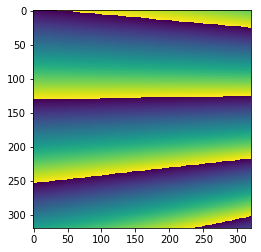

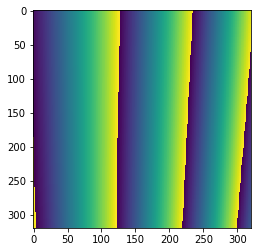

In [4]:
A = C_Q.T
A_linv = np.linalg.solve(A.T.dot(A), A.T)
C_Q_I=A_linv.T
print C_M*C_Q_I

# built new map
map0=[]
for i in range(320):
    map0.append(range(320))
map0=np.array(map0)
map1=map0+1
map2=map1.T

map1=np.reshape(map1, (1, -1))
map2=np.reshape(map2, (1, -1))
temp_p=np.vstack((map1,map2,np.ones((1, map1.shape[1]))))

M=C_M*C_Q_I

new_P=M.I* temp_p
temp_proj2 = np.divide(new_P[0:2, :], np.tile(new_P[2, :], (2,1)))

temp_proj2 -= 1

mapX = temp_proj2[0,:].astype(np.float32)
mapY = temp_proj2[1,:].astype(np.float32)

mapX = np.reshape(mapX,(-1,320), order = 'F')
mapY = np.reshape(mapY,(-1,320), order = 'F')

plt.imshow(mapX.astype('uint8'))
plt.figure()
plt.imshow(mapY.astype('uint8'))

尝试失败，分析其原因是这个逆操作并不是合理的。之前的矩阵进行了降维操作之后，再对其求逆的过程其实是将2D数据映射到3维空间的一个2D平面上。

